In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class Function:
    def __init__(self):
        self.epsilon = 1e-7

    def differentiate(self, data):
        return tf.cast((self.calcurate(data+self.epsilon) - self.calcurate(data-self.epsilon)) / (2*self.epsilon), dtype=tf.float32)

In [3]:
class Activation(Function):
    def __init__(self, name):
        super().__init__()

        self.name = name
        self.function_map = {'sigmoid' : self.sigmoid, 'relu' : self.relu, 'linear' : self.linear}
        self.weight = np.zeros((1,1))

    def sigmoid(self, data):
        return tf.math.divide(1, (1 + tf.math.pow(np.e, -data)))

    def relu(self, data):
        return tf.math.maximum(0, data)

    def linear(self, data):
        return data

    def calcurate(self, data): # activation
        return self.function_map[self.name](data)

In [4]:
class Loss(Function):
    def __init__(self, name):
        super().__init__()

        self.name = name
        self.function_map = {'mse' : self.meansquarederror, 'ce' : self.crossentropy}
        self.actual = 0

    def meansquarederror(self, predicted):
        return tf.math.reduce_mean(tf.math.pow(self.actual - predicted, 2))

    def crossentropy(self, predicted):
        return -tf.math.reduce_sum(self.actual*tf.math.log(predicted))

    def calcurate(self, data):
        return self.function_map[self.name](data)

    def evaluate(self, x, y):
        self.actual = y
        return self.function_map[self.name](x)

In [5]:
class Dense:
    def __init__(self, weight_shape, initializer="lecun", activation="linear"):
        self.name = "dense"

        self.activation = Activation(activation.lower())

        initializer_map = {"xavier" : 2/sum(weight_shape), "he" : 2/weight_shape[0]}
        weight_stddev = initializer_map.get(initializer.lower(), 1/weight_shape[0])

        self.weight = tf.Variable(tf.random.normal(shape=(weight_shape), mean=0, stddev=weight_stddev, dtype=tf.float32))
        self.bias = tf.Variable(tf.random.normal(shape=(), mean=0, stddev=0.01, dtype=tf.float32))

    def apply_gradient(self, gradient):
        self.weight.assign_sub(tf.transpose(gradient[0]))
        self.bias.assign_sub(tf.math.reduce_sum(gradient[1]))
    
    def calcurate(self, data): # propagation
        layer_output = tf.math.add(tf.matmul(data, self.weight), self.bias)
        activation_output = self.activation.calcurate(layer_output)
        return layer_output, activation_output

In [6]:
class Optimizer:
    def __init__(self, learning_rate):
        self.learning_rate = learning_rate

    def optimize(self, value):
        return self.learning_rate * value

In [7]:
class Neural_network:
    def __init__(self):
        self.network = []

    def compile(self, loss_name, optimizer_config):
        self.loss_function = Loss(loss_name)
        self.optimizer = Optimizer(optimizer_config)

    def predict(self, data):
        self.calcuration_graph = [data]

        for layer in self.network:
            hidden_data, data = layer.calcurate(data)
            self.calcuration_graph.append(hidden_data)

        return data

    def fit(self, x, y, batch_size, epochs, verbose):
        loss_graph = []

        data_num = x.shape[0]
        mini_batch_num = data_num//batch_size
        epoch_digits = len(str(epochs))

        for epoch in range(epochs):
            for batch in range(mini_batch_num):
                index = np.random.randint(data_num, size=batch_size)
                batch_x = x[index, :]
                batch_y = y[index, :]

                prediction = self.predict(batch_x)
                self.loss_function.actual = batch_y

                loss_gradient = self.loss_function.differentiate(prediction)
                self.backpropagation(-1, tf.expand_dims(tf.expand_dims(loss_gradient, axis=0), axis=1))

                loss = self.loss_function.calcurate(prediction)

                if verbose == 2:
                    print(f"epoch:{epoch}, batch:{batch}/{mini_batch_num} | loss:{tf.math.reduce_mean(loss)}")

            if verbose == 1:
                print(f"epoch:{epoch:0{epoch_digits}d} | loss:{tf.math.reduce_mean(loss):.4f}")

            loss_graph.append(loss)

        self.loss_function.actual = 0
        return np.array(loss_graph)

    def backpropagation(self, num, upstream_gradient): # recursive
        if num == -len(self.network):
            return

        activation_gradient = self.network[num].activation.differentiate(self.calcuration_graph[num])

        downstream_gradient = tf.matmul(activation_gradient, upstream_gradient)

        weight_grdient = tf.matmul(tf.transpose(downstream_gradient), self.calcuration_graph[num-1])
        bias_gradient = tf.math.reduce_sum(downstream_gradient)

        self.network[num].apply_gradient((self.optimizer.optimize(weight_grdient), self.optimizer.optimize(bias_gradient)))

        self.backpropagation(num-1, downstream_gradient)

In [8]:
x = np.array([[i] for i in range(100) for j in range(100)], dtype=np.float32)
y = x + 0.1

In [9]:
model = Neural_network()
model.network.append(Dense(weight_shape=(1, 32), activation='sigmoid'))
model.network.append(Dense(weight_shape=(32, 1), activation='linear'))

model.compile('mse', 1e-6)

2024-01-15 23:43:05.337302: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-15 23:43:05.338939: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [10]:
hist = model.fit(x, y, batch_size=64, epochs=100, verbose=1)

epoch:000 | loss:957.8201
epoch:001 | loss:1070.0156
epoch:002 | loss:874.7866
epoch:003 | loss:751.1609
epoch:004 | loss:977.6835
epoch:005 | loss:831.1857
epoch:006 | loss:936.9004
epoch:007 | loss:755.2418
epoch:008 | loss:807.1713
epoch:009 | loss:1140.9518
epoch:010 | loss:856.4460
epoch:011 | loss:771.4259
epoch:012 | loss:846.9609
epoch:013 | loss:982.6749
epoch:014 | loss:936.5532
epoch:015 | loss:1056.4600
epoch:016 | loss:1041.3781
epoch:017 | loss:927.2313
epoch:018 | loss:1113.1396
epoch:019 | loss:903.5280
epoch:020 | loss:747.3226
epoch:021 | loss:949.4065
epoch:022 | loss:951.4139
epoch:023 | loss:849.4970
epoch:024 | loss:825.0398
epoch:025 | loss:1041.7367
epoch:026 | loss:914.5704
epoch:027 | loss:540.0650
epoch:028 | loss:967.2703
epoch:029 | loss:966.1666
epoch:030 | loss:970.7130
epoch:031 | loss:705.7888
epoch:032 | loss:838.0281
epoch:033 | loss:821.5350
epoch:034 | loss:719.0059
epoch:035 | loss:953.1079
epoch:036 | loss:1165.9844
epoch:037 | loss:859.3191
epoch

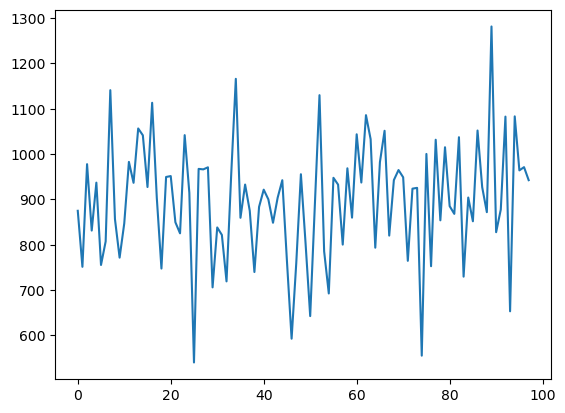

In [20]:
plt.plot(hist[2::])
plt.show()

In [12]:
model.loss_function.evaluate(model.predict(x), y)

<tf.Tensor: shape=(), dtype=float32, numpy=927.1961>

make tensorflow model to compare

In [13]:
tf_model = tf.keras.Sequential()
tf_model.add(tf.keras.layers.Dense(32, activation='relu'),)
tf_model.add(tf.keras.layers.Dense(1, activation='linear'))

tf_model.compile(loss='mse', optimizer='sgd')

In [14]:
tf_model.evaluate(x, y)

313/313 [==============================] - 1s 1ms/step - loss: 3557.6611


3557.6611328125

In [15]:
tf_hist = tf_model.fit(x, y, epochs=100, batch_size=64, verbose=1)

Epoch 1/100
157/157 [==============================] - 0s 2ms/step - loss: 8682927.0000
Epoch 2/100
157/157 [==============================] - 0s 1ms/step - loss: 980.6881
Epoch 3/100
157/157 [==============================] - 0s 2ms/step - loss: 833.6925
Epoch 4/100
157/157 [==============================] - 0s 1ms/step - loss: 833.4857
Epoch 5/100
157/157 [==============================] - 0s 1ms/step - loss: 833.2946
Epoch 6/100
157/157 [==============================] - 0s 1ms/step - loss: 833.5001
Epoch 7/100
157/157 [==============================] - 0s 2ms/step - loss: 833.4517
Epoch 8/100
157/157 [==============================] - 0s 1ms/step - loss: 833.4634
Epoch 9/100
157/157 [==============================] - 0s 1ms/step - loss: 833.5023
Epoch 10/100
157/157 [==============================] - 0s 1ms/step - loss: 833.5094
Epoch 11/100
157/157 [==============================] - 0s 2ms/step - loss: 833.4137
Epoch 12/100
157/157 [==============================] - 0s 2ms/step - 

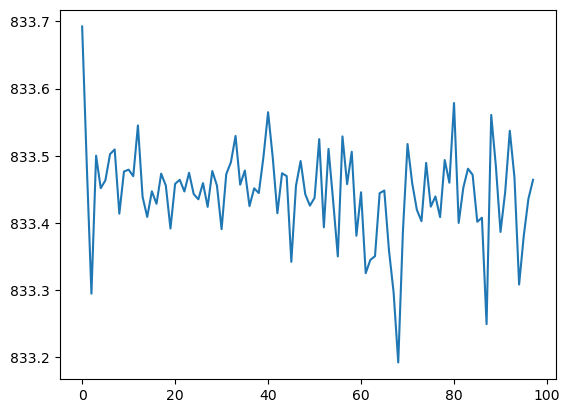

In [19]:
plt.plot(tf_hist.history['loss'][2::])
plt.show()